In [2]:
from pycqed.analysis import measurement_analysis as ma
import matplotlib.pyplot as plt
from qutip import *
import numpy as np
from numpy import array
from pycqed.analysis import analysis_toolbox as a_tools
figsave_base = "C:\\Users\\nathan\\masterthesis\\master_thesis\\chapters\\carb_gate\\figs\\"
a_tools.datadir = "Y:"
# a_tools.datadir = "Q:\\USERS\\nathan\\data\\thesis_data"

c:\users\nathan\masterthesis\code\controlsoftware\pycqed_py3\data
Data directory set to: c:\users\nathan\masterthesis\code\controlsoftware\pycqed_py3\data


Welcome to pygsti version 0.9.7!
There have been some major changes between this version and 0.9.6 - ones that break backward compatibility.  If you're trying to run an old script and nothing works, DON'T PANIC; we've tried to make the transition easy.  More often then not, you can just run `pyGSTi/scripts/upgrade2v0.9.7.py` on your old script or notebook files and you'll be up and running again.  For more information, see the pyGSTi FAQ.ipynb.

If this warning annoys you run:
  `export PYGSTI_BACKCOMPAT_WARNING=0` from the command line or
  `import os; os.environ['PYGSTI_BACKCOMPAT_WARNING'] = '0'` in a script or
     notebook *before* importing pygsti and the the madness will stop.


In [3]:
def get_parameters(timestamp, all=True, gammas=False, betas=False, iteration=False, Cs=False,
                        energy=False, correlations=False, states_filtered=False):
    """
    Get relevant parameters from the measurement file. 'all' overrides all other parameters except 
        states filtered which has to be activated manually because it loads a lot of data.
    
    """
    params = {"timestamp": t}
    a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)
    if all:
        gammas, betas, iteration, energy, correlations = [True]*5
    if gammas:
        params["gammas"] = list(a.data_file["Experimental Data"]["Experimental Metadata"]['gammas'])
    if betas:
        params["betas"] = list(a.data_file["Experimental Data"]["Experimental Metadata"]['betas'])
    if iteration:
        params["iteration"] = a.data_file["Experimental Data"]["Experimental Metadata"].attrs['iteration']
    if energy:
        params["energy"] = a.data_file['Analysis']['Processed data']['analysis_params_dict'].attrs['energy']
    if correlations:
        params["correlations"] = {n:v for n, v in zip(
            a.data_file['Analysis']['Processed data']['correlations'].attrs['names'],
            a.data_file['Analysis']['Processed data']['correlations']['values'])}
    if states_filtered:
        params["states_filtered"] = a.data_file['Analysis']['Processed data']["qb_states_filtered"]
    if Cs:
        raise NotImplementedError()
    return params

def get_parameters_run(timestamps, **kwargs):
    
    b, g, e, c, it, s = [],[],[],[], [], []
    for t in timestamps:
        params = get_parameters(t, **kwargs)
        b.append(params.get("betas", np.nan))
        g.append(params.get("gammas", np.nan))
        it.append(params.get('iteration', np.nan))
        e.append(params.get('energy', np.nan))
        c.append(params.get('correlations', np.nan))
        s.append(params.get("qb_states_filtered", np.nan))

    params_run = {}
    params_run['betas'] = np.asarray(b)
    params_run['gammas'] = np.asarray(g)
    params_run['iterations'] = np.asarray(it)
    params_run["energy"] = np.asarray(e)
    params_run["correlations"] = np.asarray(c)
    params_run["iteration_mask"] = np.asarray([e == np.amin(e[it == i]) 
                                   for i in range(max(it)+1)])
    params_run["timestamps"] = timestamps
    return params_run

def get_parameters_runs(tstart, tend, **kwargs):
    #check for label name in case interleaved tomography
    tps = a_tools.get_timestamps_in_range(tstart, tend, label="QAOA") 
    fevals = np.array([eval(a_tools.get_folder(t).split("_")[-1]) for t in tps])
    n_all_files = -np.diff(np.pad(fevals, (0,1), 'constant'))[np.diff(np.pad(fevals, (0,1), 'constant')) != 1] + 1
    all_run_params = []
    for i, nfiles in enumerate(n_all_files):
        print(tps[np.sum(n_all_files[:i])])
#         print(len(tps))
        print(tps[np.sum(n_all_files[:i]) + nfiles-1])
#         print(n_all_files)
        tmps = a_tools.get_timestamps_in_range(tps[np.sum(n_all_files[:i])], 
                                               tps[np.sum(n_all_files[:i]) + nfiles-1])
        all_run_params.append(get_parameters_run(tmps, **kwargs))
    return all_run_params

def qaoa_propagator(n_qbs, two_qb_pairs, gammas, betas, Cs, hs):
    q = QubitCircuit(n_qbs, reverse_states=False)
    qubits = np.arange(n_qbs)

    assert len(Cs) == len(two_qb_pairs), f"Cs and two_qb_pairs do not match: {len(Cs) } vs {len(two_qb_pairs)}"
    
    # init
    for qb in qubits:
        q.add_gate("RY", targets=qb, arg_value=np.pi/2, arg_label=r'\frac{\pi}{2}')

    for g, b in zip(gammas, betas):
        for C, pair in zip(Cs, two_qb_pairs):
            q.add_gate("RZ", targets=pair[0], arg_value=-2*g*C, arg_label=r'-2\gamma C')
            q.add_gate("RZ", targets=pair[1], arg_value=-2*g*C, arg_label=r'-2\gamma C')
            q.add_gate("CPHASE", controls=pair[0], targets=pair[1], arg_value=(4*g*C) % (2*np.pi), arg_label=r'4\gamma C')
        for k,h in enumerate(hs):
            q.add_gate("RZ", targets=[k], arg_value=2*g*h, arg_label=r'-2\gamma C')

        # D
        for qb in qubits:
            q.add_gate("RX", targets=qb, arg_value=b, arg_label=r'\beta')

    U_list = q.propagators()
    return gate_sequence_product(U_list)

def cs_to_phys(labels):
    """
    changes list of labels '[0 1 0]' --> '$|010\rangle$'
    """
    labels = [str(l) for l in labels]
    return ["$|{}\\rangle$".format(l.translate({ord(i): None for i in '[() ],'})) 
            for l in labels]
    
def bar_plot(timestamp, gammas=None, betas=None, Cs=None, hs=None, 
             two_qb_pairs='linear_array', correct_states=None, plot=True, save=False):
    """
    Creates histogram bar plot of measured states.
    Correct state formart: [b1 b2 ... bn]
    """
    results = {}
    
    # get qb states and parameters
    a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)
    states = np.asarray(a.data_file['Analysis']["Processed data"]["qubit_states"])
    results['states'] = states
    n_qbs = states.shape[1]
    qubits = np.arange(n_qbs)
    try:
        if gammas is None:
            gammas = a.data_file["Experimental Data"]["Experimental Metadata"]['gammas']
        if betas is None:
            betas = a.data_file["Experimental Data"]["Experimental Metadata"]['betas']
    except TypeError:
        gammas = [eval(a.data_file["Experimental Data"]["Experimental Metadata"]['gammas'])]
        betas = [eval(a.data_file["Experimental Data"]["Experimental Metadata"]['betas'])]
    
    results["depth"] = len(gammas)
    # counts for each label
    states_labels, counts = np.unique(states, axis=0, return_counts=True)
    states_labels = np.array(cs_to_phys([str(s) for s in states_labels]))
    filter = [True if not "2" in s else False for s in states_labels]
    if correct_states is not None:
        correct_states = cs_to_phys(correct_states)
        counts_in_subspace = np.sum(counts[filter])
        success_prob = np.sum([counts[states_labels == c] for c in correct_states]) / counts_in_subspace
        results["success_prob"] = success_prob
        
    #qutip computation of expected state
    if Cs is None:
        _, Cs = qaoa.QAOAHelper.get_corr_and_coupl_info(
            eval(a.data_file["Experimental Data"]["Experimental Metadata"].attrs['two_qb_gates_info']))
    if hs is None:
        hs = [0 for _ in range(n_qbs)]
    if two_qb_pairs == "linear_array":
        two_qb_pairs = [(i,j) for i,j in zip(qubits, qubits[1:]) ] 
    else:
        raise NotImplementedError()
        
    U = qaoa_propagator(n_qbs, two_qb_pairs, gammas, betas, Cs, hs)
    H = U * ket("0"*len(qubits))
    results['expected_state'] = np.real((H*H.dag()).full()[np.eye(len(H.full()), dtype=bool)])
    results["expected_state_labels"] = np.array(cs_to_phys(list(itertools.product((0,1), repeat=n_qbs))))
    if correct_states is not None:
        success_prob_theory = np.sum([results['expected_state'][results["expected_state_labels"] == c] for c in correct_states])
        results['success_prob_theory'] = success_prob_theory
        
    if plot:
        fig, ax = plt.subplots()
        order = list(reversed(np.argsort(counts[filter])))
        expected_state_labels_in_mmnt = [True if sl in states_labels[filter][order] else False for sl in results["expected_state_labels"]]
        ax.bar(states_labels[filter][order], counts[filter][order]/np.sum(counts[filter]),
              color='grey')
        ax.bar(results["expected_state_labels"][expected_state_labels_in_mmnt] , results['expected_state'][expected_state_labels_in_mmnt], 
               fill=False, linewidth=1, edgecolor='k', 
               label="$P_s$ noise-free sim.: {:.3f}".format(success_prob_theory))
        if correct_states is not None:
            correct_states_counts = np.asarray([counts[states_labels == c]/np.sum(counts[filter]) for c in correct_states])
            
            ax.bar(correct_states, correct_states_counts.flatten() , 
                   color='green', label="$P_s$: {:.3f}".format(success_prob))
            ax.legend()
        plt.xticks(states_labels[filter],  rotation='vertical')
        ax.set_ylabel("Fraction of measurements (arb. u.)")

        results['fig'] = fig
        if save:
            fig.tight_layout()
            fig.savefig(a.folder + "\\bit_strings_frequency.png")
            
    return results

In [4]:
# landscape functions
from IPython.display import clear_output 
from copy import deepcopy
def plot_colormesh(xx, yy, zz, **plot_kwargs):
    fig, ax = plt.subplots()
    plot_kwargs = deepcopy(plot_kwargs)
    vmin = plot_kwargs.pop("vmin", -1)
    vmax = plot_kwargs.pop("vmax", 1)
    cmap = plot_kwargs.pop("cmap", "seismic")
    im = ax.pcolormesh(np.pad(xx,(1,0), "linear_ramp"), np.pad(yy,(1,0), "linear_ramp"), zz, cmap=cmap, 
                       **plot_kwargs)
    ax.set_xlabel("gamma (rad.)")
    ax.set_ylabel("beta (rad.)")
    cb = fig.colorbar(im, label=r"$\sigma_z \sigma_z$ (arb. u.)")
def load_landscape_from_analyzed_files(tstart, tend, save=False, plot=True):
    tps = a_tools.get_timestamps_in_range(tstart, tend)
    energy = []
    leakages = {}
    gammas = []
    betas = []
    an = []
    for j, t in enumerate(tps):
        print(j)
        a = ma.MeasurementAnalysis(timestamp=t, auto=False)
        gammas.append(np.array(a.data_file["Experimental Data"]["Experimental Metadata"]['gammas']))
        betas.append(np.array(a.data_file["Experimental Data"]["Experimental Metadata"]['betas']))
        e = list(a.data_file["Analysis"]["Processed data"]["analysis_params_dict"]["energy"])
        for qb, leak in a.data_file["Analysis"]["Processed data"]["analysis_params_dict"]["leakage"].items():
            if qb not in leakages:
                leakages[qb] = []
            leakages[qb].append(list(a.data_file["Analysis"]["Processed data"]["analysis_params_dict"]["leakage"][qb]))
        energy.append(e)
        an.append(a)
    clear_output()
    
    gg, bb, energy =  np.asarray(gammas),  np.asarray(betas), np.asarray(energy)
    print(gg.shape)
    print(bb.shape)
    print(energy.shape)
    if save:
        f = a.folder
        np.save(f + "\\gammas.npy", gg)
        np.save(f + "\\betas.npy", bb)
        np.save(f + "\\energy.npy", energy)
        for qb in leakages:
            np.save(f + f"\\leakage_{qb}.npy", leakages[qb])
    if plot:
        # plot landscape
        fig, ax = plt.subplots()
        cmap = "seismic"
        im = ax.pcolormesh(np.pad(gg,(1,0), "linear_ramp"), np.pad(bb,(1,0), "linear_ramp"), 
                           energy, cmap=cmap, vmin=-1.05, vmax=1.05)
        ax.set_xlabel("gamma (rad.)")
        ax.set_ylabel("beta (rad.)")
        cb = fig.colorbar(im, label=r"Energy (arb. u.)")
        if save:
            fig.savefig(f + "\\energy_landscape.png")
        # plot leakage
        for qb in leakages:
            fig, ax = plt.subplots()
            im = ax.pcolormesh(np.pad(gg,(1,0), "linear_ramp"), np.pad(bb,(1,0), "linear_ramp"), leakages[qb])
            ax.set_xlabel("gamma (rad.)")
            ax.set_ylabel("beta (rad.)")
            cb = fig.colorbar(im, label=f"leakage {qb}")
            if save:
                fig.savefig(f + f"\\leakage_{qb}.png")
            
    return np.asarray(gammas), np.asarray(betas), energy, leakages, an

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def plot_style():
    font_size       = 16
    marker_size     = 6
    line_width      = 2.5
    axes_line_width = 1
    tick_length     = 5
    tick_width      = 1
    tick_color      = 'k'
    ticks_direction = 'in'
    axes_labelcolor = 'k'

    fig_size_dim    = 8
    golden_ratio    = (1+np.sqrt(5))/2
    fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)
    dpi             =  300

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "DINPro",#"cmss10", #"DINPro", # to manage to use dinpro, put ttf files in site-packages/matplotlib/mpl-data/fonts
              'mathtext.default': 'it',
              'mathtext.fontset': "cm",
              'mathtext.it': 'cm',
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.labelcolor': axes_labelcolor,
              'axes.titlesize': font_size,
              'axes.linewidth': axes_line_width,
              'lines.markersize': marker_size,
              'lines.linewidth': line_width,
              'xtick.direction': ticks_direction,
              'ytick.direction': ticks_direction,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'xtick.color': tick_color,
              'ytick.color': tick_color,
              'xtick.major.size': tick_length,
              'ytick.major.size': tick_length,
              'xtick.major.width': tick_width,
              'ytick.major.width': tick_width,
              'xtick.top': True,
              'xtick.bottom': True,
              'ytick.left': True,
              'ytick.right': True,
              'axes.formatter.useoffset': False,

              # LEGEND
            'legend.loc'           : 'best',
            'legend.frameon'       : False,     ## if True, draw the legend on a background patch
    #         'legend.framealpha'    : 0.8,      ## legend patch transparency
    #         'legend.facecolor'     : 'inherit',  ## inherit from axes.facecolor; or color spec
    #         'legend.edgecolor'     : 0.8,      ## background patch boundary color
    #         'legend.fancybox'      : True,     ## if True, use a rounded box for the
                                             ## legend background, else a rectangle
                }

    plt.rcParams.update(params)
plot_style()

def get_color_list(N, base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    return base(np.linspace(0, 1, N))
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    color_list = get_color_list(N, base_cmap=base_cmap)
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

Text(0.5, 0, 'Hours, $t$ (h)')

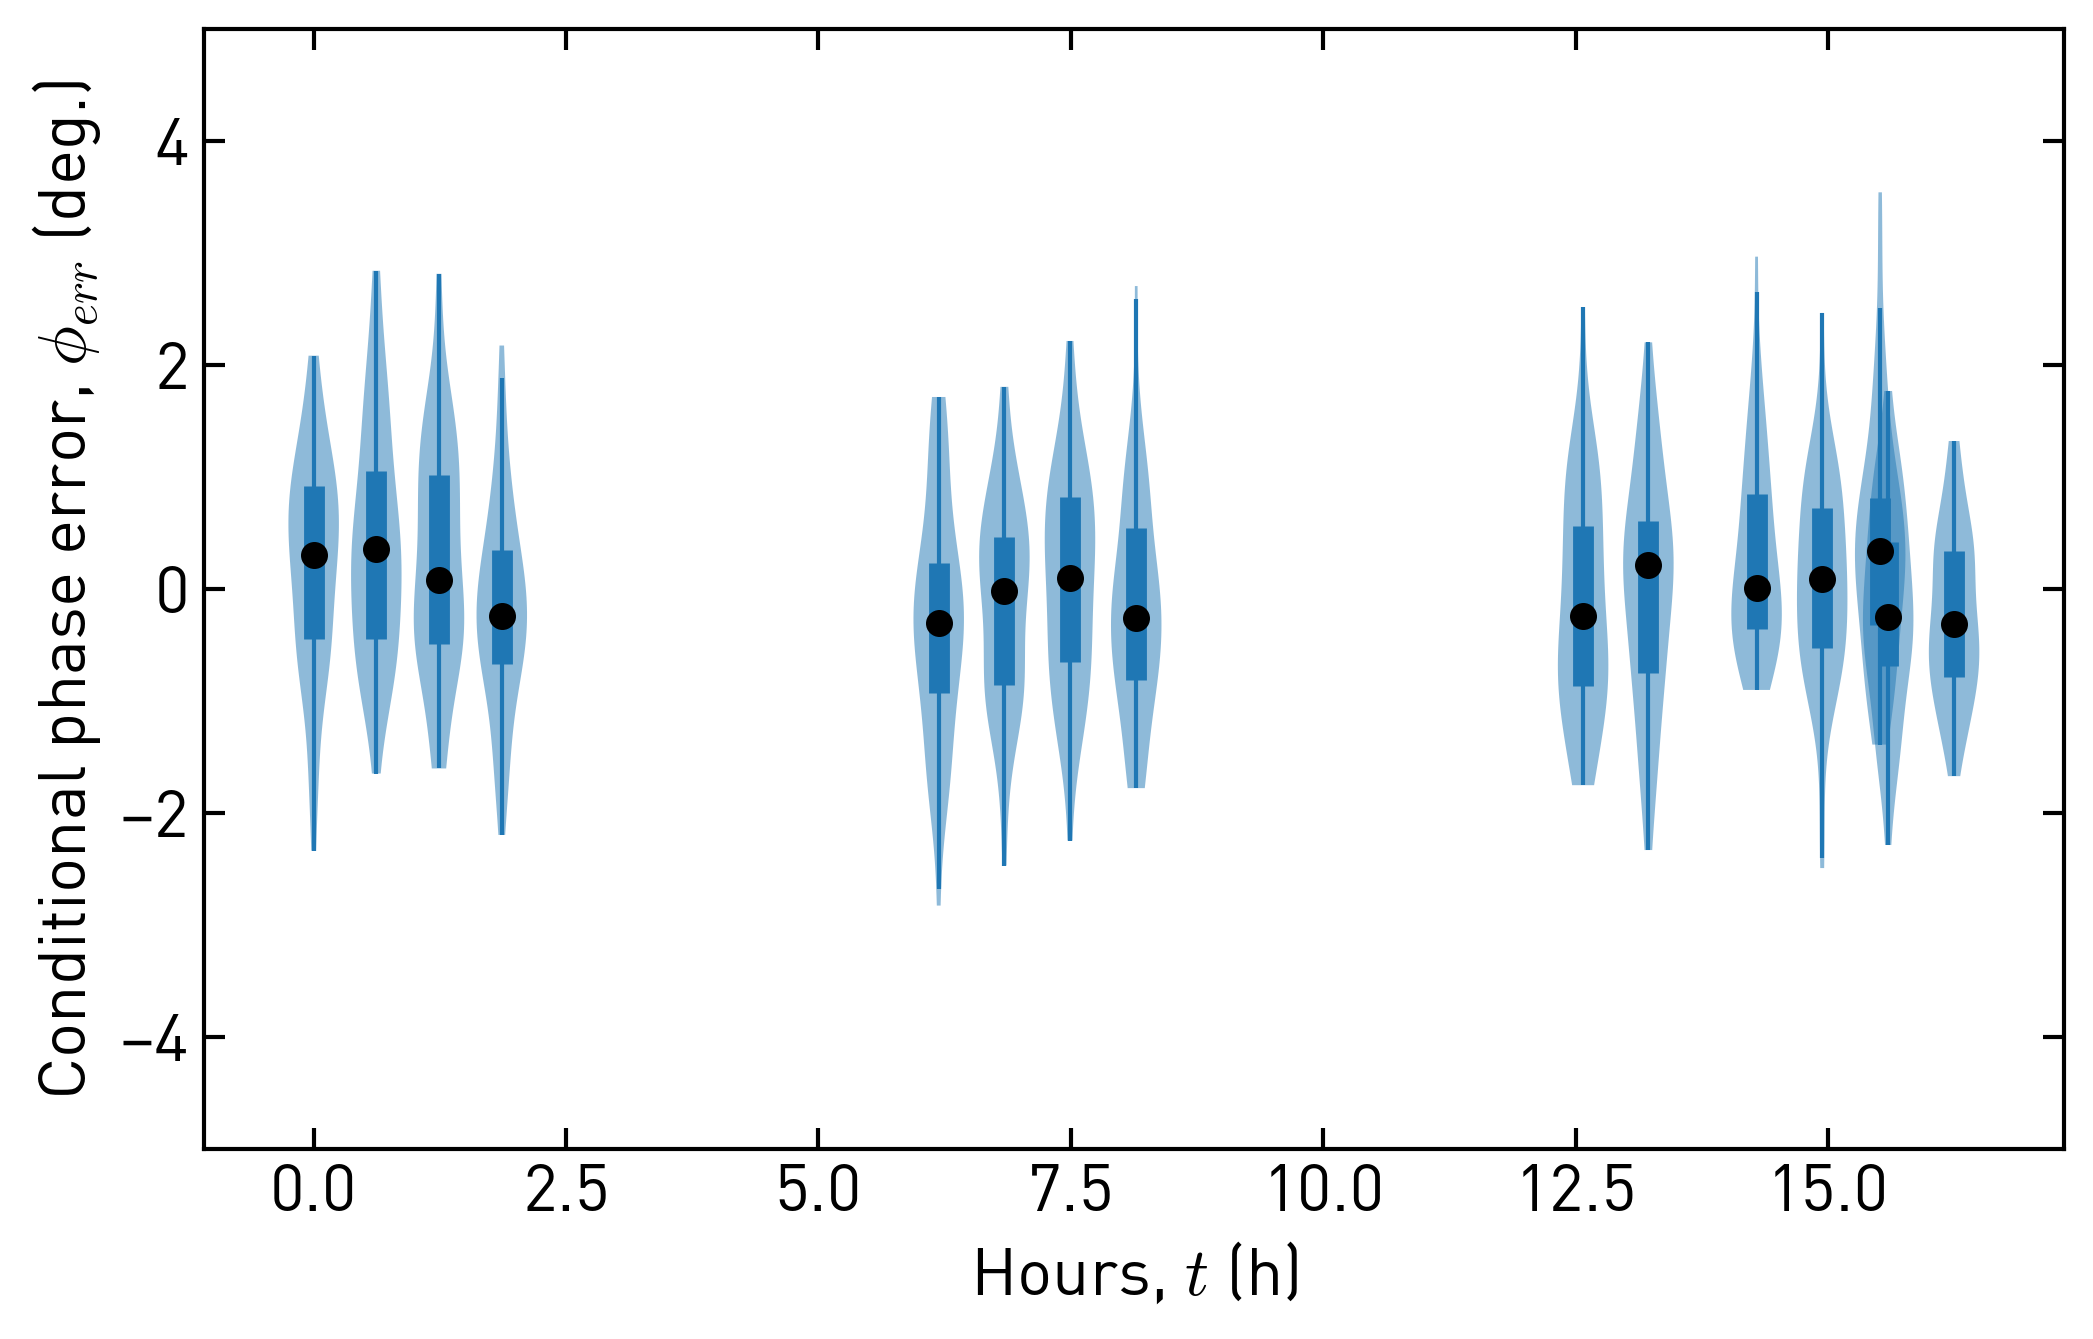

In [116]:
# cphase diff over time
fig, ax = plt.subplots()
# ax.set_prop_cycle(color=[plt.get_cmap("Dark2")(i) for i in np.linspace(0,1,8)])
# ax.errorbar(timestamps, [np.mean(r['cphases_diff']) for r in results.values()], 
#             [np.std(r['cphases_diff']) for r in results.values()], marker='o', fmt=' ',)
# ax.set_xticklabels(labels=timestamps, rotation = (90), fontsize = 10, va='bottom', ha='left')
parts = ax.violinplot(data, showmeans=False, positions=td, showextrema=False)
for pc in parts['bodies']:
#     pc.set_facecolor('#D43F3A')
#     pc.set_edgecolor('black')
    pc.set_alpha(0.5)

quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]


ax.scatter(td, medians, marker='o', color='black', s=30, zorder=3)
ax.vlines(td, quartile1, quartile3, color='C0', linestyle='-', lw=5)
ax.vlines(td, whiskersMin, whiskersMax, color='C0', linestyle='-', lw=1)
ax.set_ylim([-5,5])
ax.set_ylabel("Conditional phase error, $\phi_{err}$ (deg.)")
ax.set_xlabel('Hours, $t$ (h)')

In [14]:
# convert to gate infidelity
target_unitaries = [np.diag([1,1,1, np.exp(1j*tph)]) for tph in target_phases]

gate_infidelities = []
for r in np.array(list(results.values())):
    exp_unitaries = [np.diag([1, 1, 1, np.exp(1j*( tph + r['cphases_diff'][i]*np.pi/180 ))]) for i, tph in zip(range(len(r['cphases_diff'])),
                                                                                                 target_phases )]
    gate_infidelities.append([1-average_gate_fidelity(Qobj(u_exp, dims=[[2], [2]]), Qobj(u_t, dims=[[2], [2]]))**2 
                              for u_exp, u_t in zip(exp_unitaries, target_unitaries)])

Text(0, 0.5, 'Conditional phase error, $\\phi_{err}$ (deg.)')

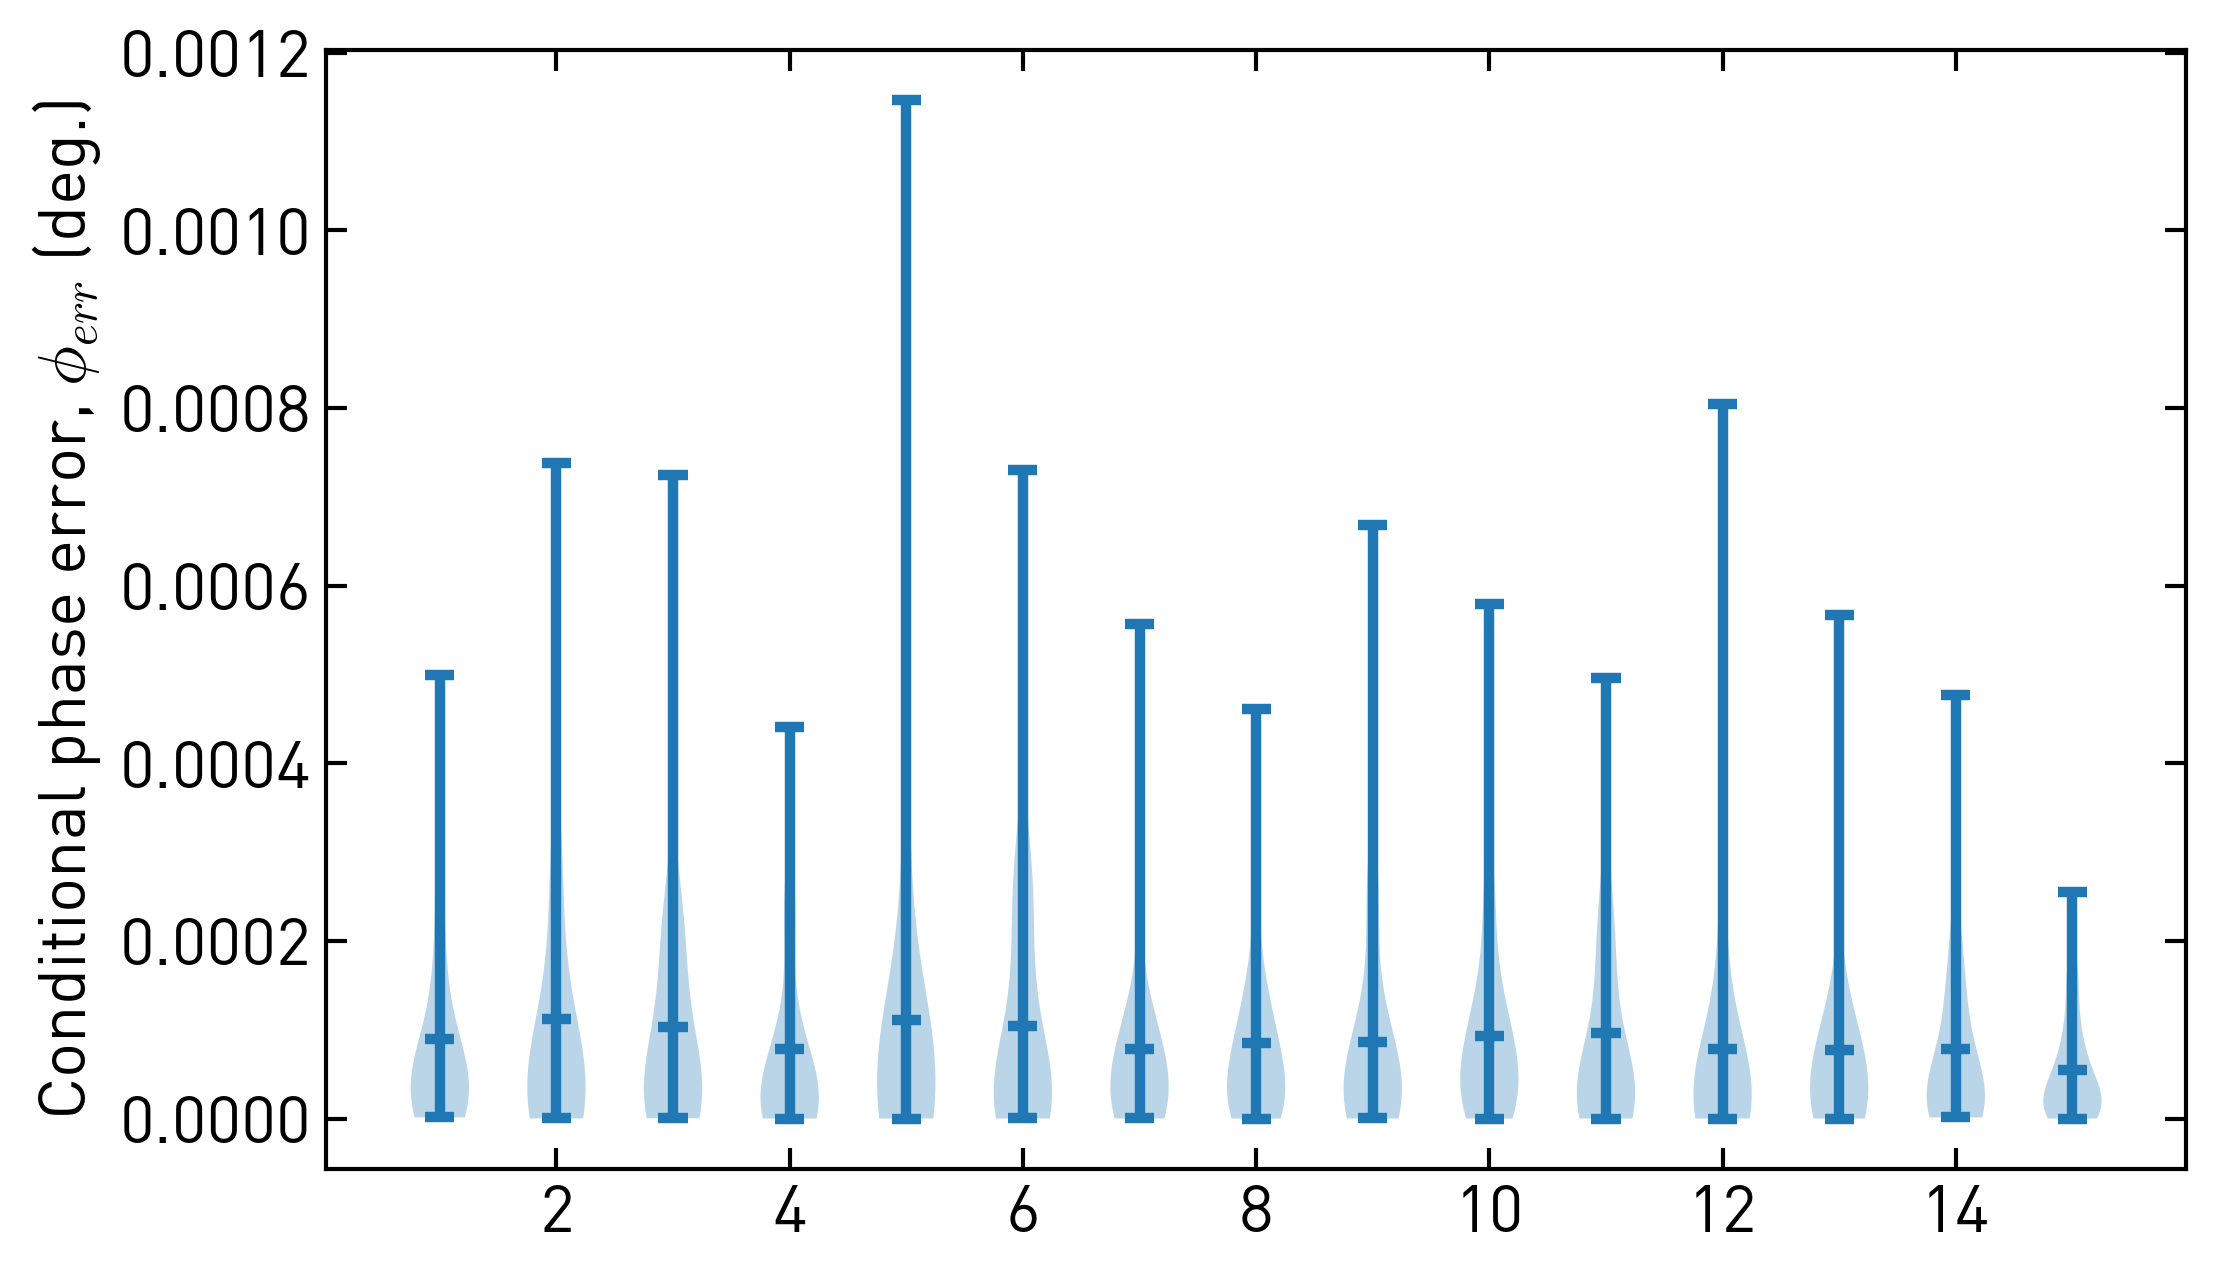

In [15]:
# cphase diff over time
fig, ax = plt.subplots()
# ax.errorbar(timestamps, [np.mean(r['cphases_diff']) for r in results.values()], 
#             [np.std(r['cphases_diff']) for r in results.values()], marker='o', fmt=' ',)
# ax.set_xticklabels(labels=timestamps, rotation = (90), fontsize = 10, va='bottom', ha='left')
ax.violinplot(gate_infidelities, showmeans=True)
# ax.set_ylim([-5,5])
ax.set_ylabel("Conditional phase error, $\phi_{err}$ (deg.)")

# Time comparison of CZ and CARB

## Load CZ data

In [5]:
# load from results arrays for CZ
# tstart = "20191211_000000"
# tend = "20191211_090302"
tstart = "20191211_113144"
tend = "20191212_040000"
label = "Dynamic_phase"
tps = a_tools.get_timestamps_in_range(tstart, tend, label=label)
print(len(tps))



832


In [6]:
# load only cphase
# results_cz = {}
# from datetime import datetime
# for t in tps:
#     try:
#         a = ma.MeasurementAnalysis(timpestamp=t, auto=False)
#         results_cz[t] = -180+ 180/np.pi*np.array(a.data_file['Analysis']["Processed data"]['analysis_params_dict']["cphase"]['val'])
#     except:
#         pass
# timestamps_cz = [datetime.strptime(t, '%Y%m%d_%H%M%S') for t in results]
# print(len(results_cz))
# load cphase and dyn phase
results_cz = {}
from datetime import datetime
for t in tps:
    try:
        f = a_tools.get_folder(t)
        results_cz[t] = np.load(f + "\\results.npy", allow_pickle=True)[0]
    except:
        pass
timestamps_cz = [datetime.strptime(t, '%Y%m%d_%H%M%S') for t in results_cz]
print(len(results_cz))

17


In [7]:
## prepare data for plot

# find phases at which points were evaluated: auto
# tstart = "20191208_000000"
# tend = "20191211_161222"
# label = "CPhase"
# tps = a_tools.get_timestamps_in_range(tstart, tend, label=label)
# print(len(tps))
# a = ma.MeasurementAnalysis(timestamp=tps[0], auto=False) 
# NOT FINISHED


# manual phases
target_phases = np.array([np.pi]*45)

# convert timestamps to hours
td_cz = [(t - timestamps_cz[0]).seconds/3600 for t in timestamps_cz]

# data cond ph
data_cph_cz = [sorted((r['cphases'] - np.pi)*180/np.pi) for r in results_cz.values()]
means_cph_cz = [np.mean((r['cphases'] - np.pi)*180/np.pi) for r in results_cz.values()]
std_cph_cz = [np.std((r['cphases'] - np.pi)*180/np.pi) for r in results_cz.values()]
ref_cph = np.pi #[np.mean(r['cphases']) for r in results_cz.values()][0]

# data dyn ph
calibration_dph = list(results_cz.values())[0]['dyn_phase'][0]
data_dph_cz = [sorted(np.array(r['dyn_phase']) % 360  - (calibration_dph % 360)) for r in results_cz.values()]
means_dph_cz = [np.mean(np.array(r['dyn_phase']) % 360  - (calibration_dph % 360)) for r in results_cz.values()]
std_dph_cz = [np.std(np.array(r['dyn_phase']) % 360  - (calibration_dph % 360)) for r in results_cz.values()]
ref_dph = means_dph_cz[0]

# translate to gate infidelity
target_unitaries = [np.diag([1,1,1, np.exp(1j*ref_cph)]) for _ in target_phases]
gate_infidelities_cz = []
for cph, dph in zip(data_cph_cz, data_dph_cz):
    exp_unitaries = [np.diag([1, 1, np.exp(1j*dph_i*np.pi/180), np.exp(1j*( ref_cph + cph_i*np.pi/180 ))]) 
                     for cph_i, dph_i in zip(cph, dph)  ]
    gate_infidelities_cz.append([100-100*average_gate_fidelity(Qobj(u_exp, dims=[[2], [2]]), Qobj(u_t, dims=[[2], [2]]))**2 
                              for u_exp, u_t in zip(exp_unitaries, target_unitaries)]) #squared because sqrt in qtp def
means_infid_cz = np.mean(gate_infidelities_cz, axis=1)
std_infid_cz = np.std(gate_infidelities_cz, axis=1)

# data leakage
data_leakage_cz = [sorted(r['leakage']) for r in results_cz.values()]
means_leakage_cz = [np.mean(r['leakage']) for r in results_cz.values()]
std_leakage_cz = [np.std(r['leakage']) for r in results_cz.values()]


## Load CARB data

In [8]:
# get timestamps for cph dyn ph
tstart = "20191208_000000"
tend = "20191210_220000" #"20191211_161222"
label = "Dynamic_phase"
tps = a_tools.get_timestamps_in_range(tstart, tend, label=label)
print(len(tps))

# get timestamps of measurements for leakage (need the Arb measurement and not the results.npy)
tstart = "20191208_230000"
tend = "20191210_220000" #"20191211_161222"
label = "Arbitrary_Phase_qb3_qb2"
tps_leakage = a_tools.get_timestamps_in_range(tstart, tend, label=label)
print(len(tps_leakage))

1143
26


In [9]:
# load results cph dyn ph
results = {}
stop = 15
from datetime import datetime

for t in tps:
    try:
        if len(results) >= stop:
            continue
        f = a_tools.get_folder(t)
        results[t] = np.load(f + "\\results.npy", allow_pickle=True)[0] #conditional phase is stored in first array (?)
    except:
        pass
timestamps = [datetime.strptime(t, '%Y%m%d_%H%M%S') for t in results]
print(len(results))

15


In [10]:
# load leakage data
stop = 15

data_leakage_carb = []
for t in tps_leakage:
    if len(data_leakage_carb) == stop:
        break
    try:
        m = ma.MeasurementAnalysis(timestamp=t, auto=False)
        data_leakage_carb.append(np.array(m.data_file["Analysis"]["Processed data"]['analysis_params_dict']['leakage']['val']))
    except: 
        pass
means_leakage_carb = np.mean(data_leakage_carb, axis=1)
std_leakage_carb = np.std(data_leakage_carb, axis=1)


In [11]:
## prepare plot

# manual target phases
target_phases = np.linspace(0, 2*np.pi, 45)

# convert timestamps to hours
td = [(t - timestamps[0]).seconds/3600 for t in timestamps]

# data
data_cph_carb = [sorted(r['cphases_diff']) for r in results.values()]
means_cph_carb = [np.mean(r['cphases_diff']) for r in results.values()]
std_cph_carb = [np.std(r['cphases_diff']) for r in results.values()]

data_dph_carb = [sorted(r['dphases_diff']) for r in results.values()]
means_dph_carb = [np.mean(r['dphases_diff']) for r in results.values()]
std_dph_carb = [np.std(r['dphases_diff']) for r in results.values()]

In [12]:
colors = ["#3673AF", "#39B265", "#734687", "#873D48", "#2D3142"]

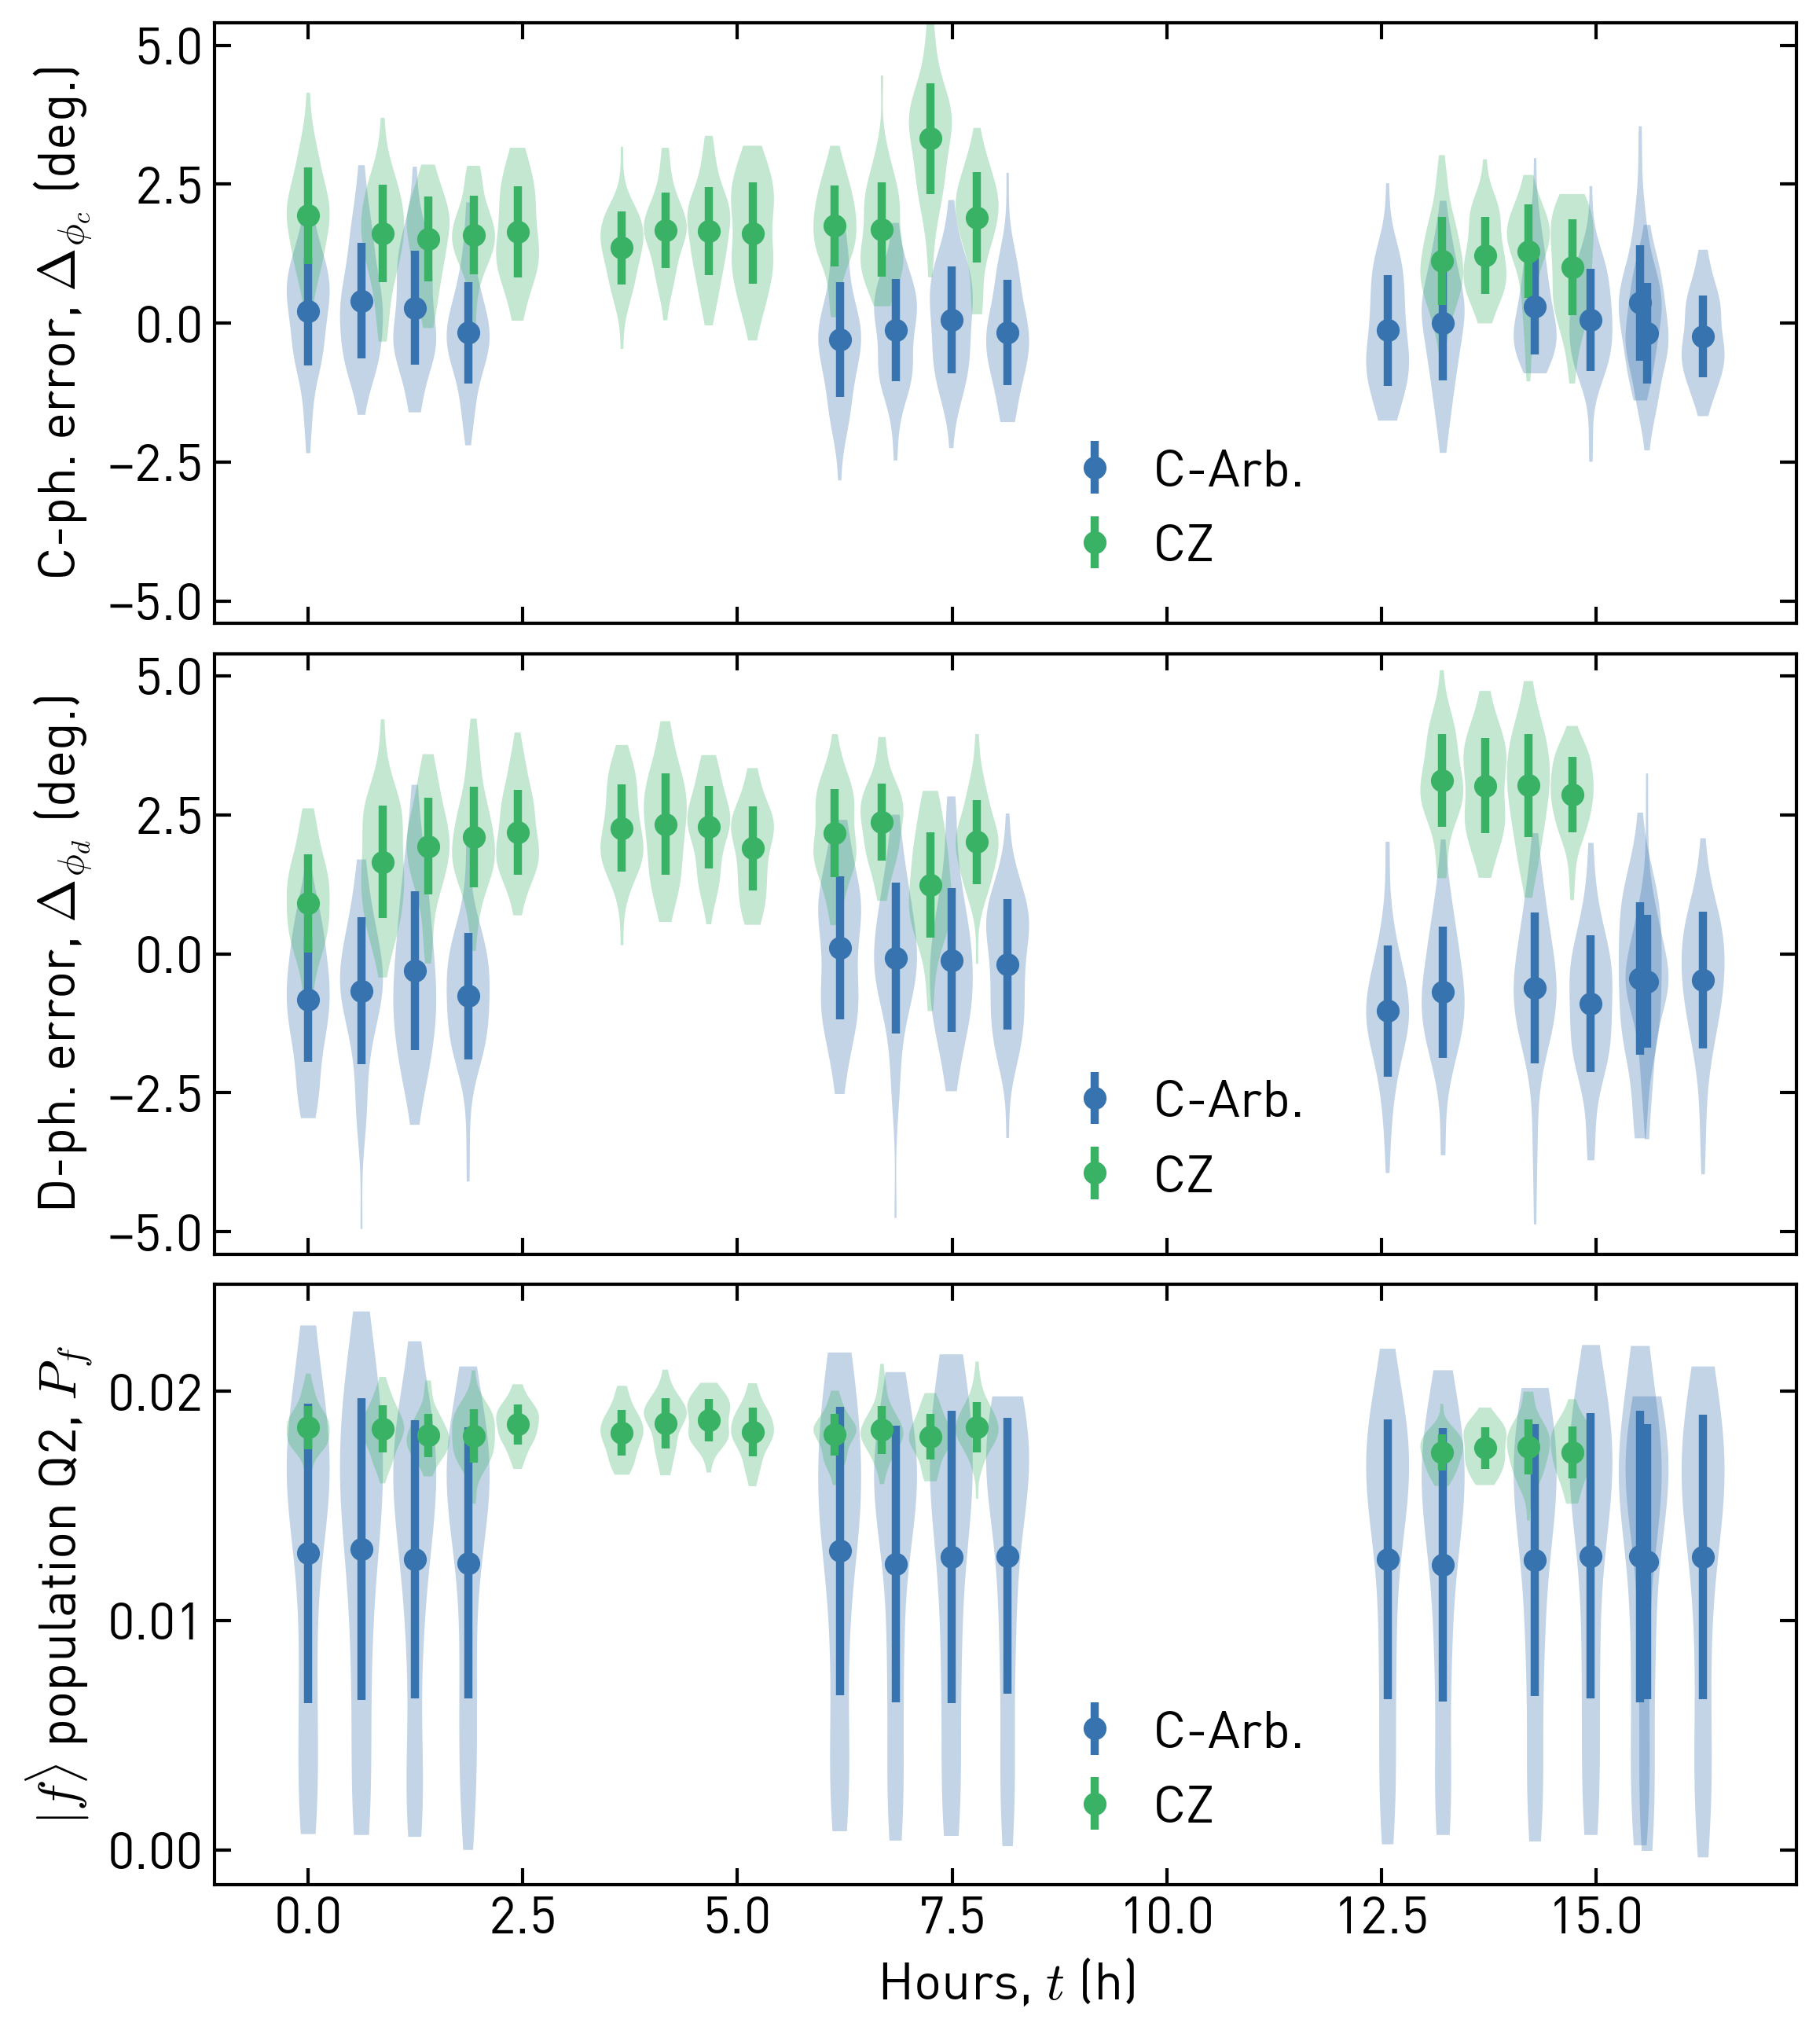

In [23]:
fig, ax = plt.subplots(3, sharex=True, figsize=(8,9))
# colors = get_color_list(2, 'Accent')

# COND PH
ax[0].set_prop_cycle(color=["#3673AF", "#39B265"])

# ax[0].set_prop_cycle(color=["#013563", "#3673AF" ])
ax[0].set_ylim([-3.6 * 1.5, 3.6 * 1.5])
ax[0].set_ylabel("C-ph. error, $\Delta_{\phi_c}$ (deg.)")
# violin plot
ax[0].violinplot(data_cph_carb, showmeans=False, positions=td, showextrema=False)  #carb
ax[0].violinplot(data_cph_cz, showmeans=False, positions=td_cz, showextrema=False) #cz

ax[0].errorbar(td, means_cph_carb, std_cph_carb, marker='o', label='C-Arb.',  fmt=" ")
ax[0].errorbar(td_cz, means_cph_cz, std_cph_cz, marker='o', label='CZ',  fmt=" ")

ax[0].legend(loc=(0.51, 0.05), handletextpad=0.1)

# DYN PH
# ax[1].set_prop_cycle(color=["darkgreen","#39B265", ])
ax[1].set_prop_cycle(color=["#3673AF", "#39B265"])

ax[1].set_ylim([-3.6 * 1.5, 3.6 * 1.5])
ax[1].set_ylabel("D-ph. error, $\Delta_{\phi_d}$ (deg.)")

# violin plot

ax[1].violinplot(data_dph_carb,
                 showmeans=False,
                 showextrema=False,
                 positions=td)  #carb
ax[1].violinplot(data_dph_cz,
    showmeans=False,
    showextrema=False,
    positions=td_cz)  #cz

ax[1].errorbar(td, means_dph_carb,std_dph_carb, marker='o',
            label='C-Arb.', alpha=1,  fmt=" ")
ax[1].errorbar(td_cz, means_dph_cz , std_dph_cz, marker='o',
            label='CZ', alpha=1,  fmt=" ")

ax[1].legend(loc=(0.51, 0.05), handletextpad=0.1)

# LEAKAGE
ax[2].set_prop_cycle(color=["#3673AF", "#39B265"])
# violin
ax[2].violinplot(data_leakage_carb, showmeans=False, positions=td, showextrema=False) #carb
ax[2].violinplot(data_leakage_cz, showmeans=False, positions=td_cz, showextrema=False) #cz

ax[2].errorbar(td, means_leakage_carb, std_leakage_carb, marker='o',
            label='C-Arb.', alpha=1,  fmt=" ")

ax[2].errorbar(td_cz, means_leakage_cz , std_leakage_cz, marker='o',
            label='CZ', alpha=1,  fmt=" ")

ax[2].legend(loc=(0.51, 0.05), handletextpad=0.1)
ax[2].set_ylabel(r"$|f\rangle$ population Q2, $P_f$")
ax[2].set_xlabel("Hours, $t$ (h)")

fig.tight_layout()
plt.subplots_adjust(hspace=0.05)


# # GATE INFIDELITY
# # violin plot
# # ax[2].violinplot(gate_infidelities_carb, showmeans=True, positions=td) #carb
# ax[2].violinplot(gate_infidelities_cz, showmeans=True, positions=td_cz)  #cz
# ax[2].set_prop_cycle(color=colors)
# # # errobar plot
# # ax[2].errorbar(td, means_dph_carb - means_dph_carb[0], std_dph_carb, marker='o', fmt=' ',
# #             label='C-Arb.', capsize=0, alpha=0.8)
# ax[2].errorbar(td_cz,
#                means_infid_cz,
#                std_infid_cz,
#                marker='o',
#                fmt=' ',
#                label='CZ',
#                capsize=0,
#                alpha=0.8)
# ax[2].set_ylabel("Gate infidelity, $\Delta_{g}$ (%)")
# ax[2].set_xlabel("Hours, $t$ (h)")
# ax[1].legend()

In [24]:
fig.savefig(figsave_base + "ch4_characterization_drift_{:%Y%m%d_%H%M%S}.png".format(datetime.now()))

In [32]:
print(np.mean(std_dph_cz))
print(np.mean(std_dph_carb))
print()
print(np.mean(std_cph_cz))
print(np.mean(std_cph_carb))

0.8296424529105866
1.2570232285805072

0.8032478696984164
0.9530058432263512


## Characterization of errors over angles

### plot over angle


In [25]:
# load data carb
t_cph_carb = "20191208_221428"
m = ma.MeasurementAnalysis(timestamp=t_cph_carb, auto=False)
target_phases = np.array(m.data_file["Experimental Data"]["Experimental Metadata"]['target_phases'])
phase_func = eval(m.data_file["Experimental Data"]["Experimental Metadata"].attrs['phase_func'])
cph_carb = np.array(m.data_file["Analysis"]["Processed data"]['analysis_params_dict']['cphase']['val'])
pop_loss = np.array(m.data_file["Analysis"]["Processed data"]['analysis_params_dict']['population_loss']['val'])

cph_carb_std = np.array(m.data_file["Analysis"]["Processed data"]['analysis_params_dict']['cphase']['stderr'])
cph_carb_angle_error = ((cph_carb - target_phases +  np.pi) % (2*np.pi) -np.pi )*180/np.pi
data_leakage_carb = np.array(m.data_file["Analysis"]["Processed data"]['analysis_params_dict']['leakage']['val'])
data_leakage_carb_std = 0.5/np.sqrt(50000) # worst case

In [26]:
# load data dyn ph for carb
tstart = "20191208_223154"
tend = "20191208_225236"
label = "Dynamic_phase"
tps = a_tools.get_timestamps_in_range(tstart, tend, label=label)
dph_carb = []
dph_carb_std = []
for t in tps:
    m = ma.MeasurementAnalysis(timestamp=t, auto=False)
    dph_carb.append(m.data_file["Analysis"]["Processed data"]['analysis_params_dict']['qb3']['dynamic_phase'].attrs['val'])
    dph_carb_std.append(m.data_file["Analysis"]["Processed data"]['analysis_params_dict']['qb3']['dynamic_phase'].attrs['stderr'])

dph_carb = np.array(dph_carb)
dph_carb_std = np.array(dph_carb_std)
dph_carb_angle_error = (dph_carb*180/np.pi - phase_func(target_phases)[1] + 180) % 360 - 180

In [ ]:
["#3673AF", "#39B265", "#734687", "#873D48", "#2D3142"]

In [27]:
colors = ["#3673AF", "#39B265", "#734687", "#873D48", "#2D3142"]

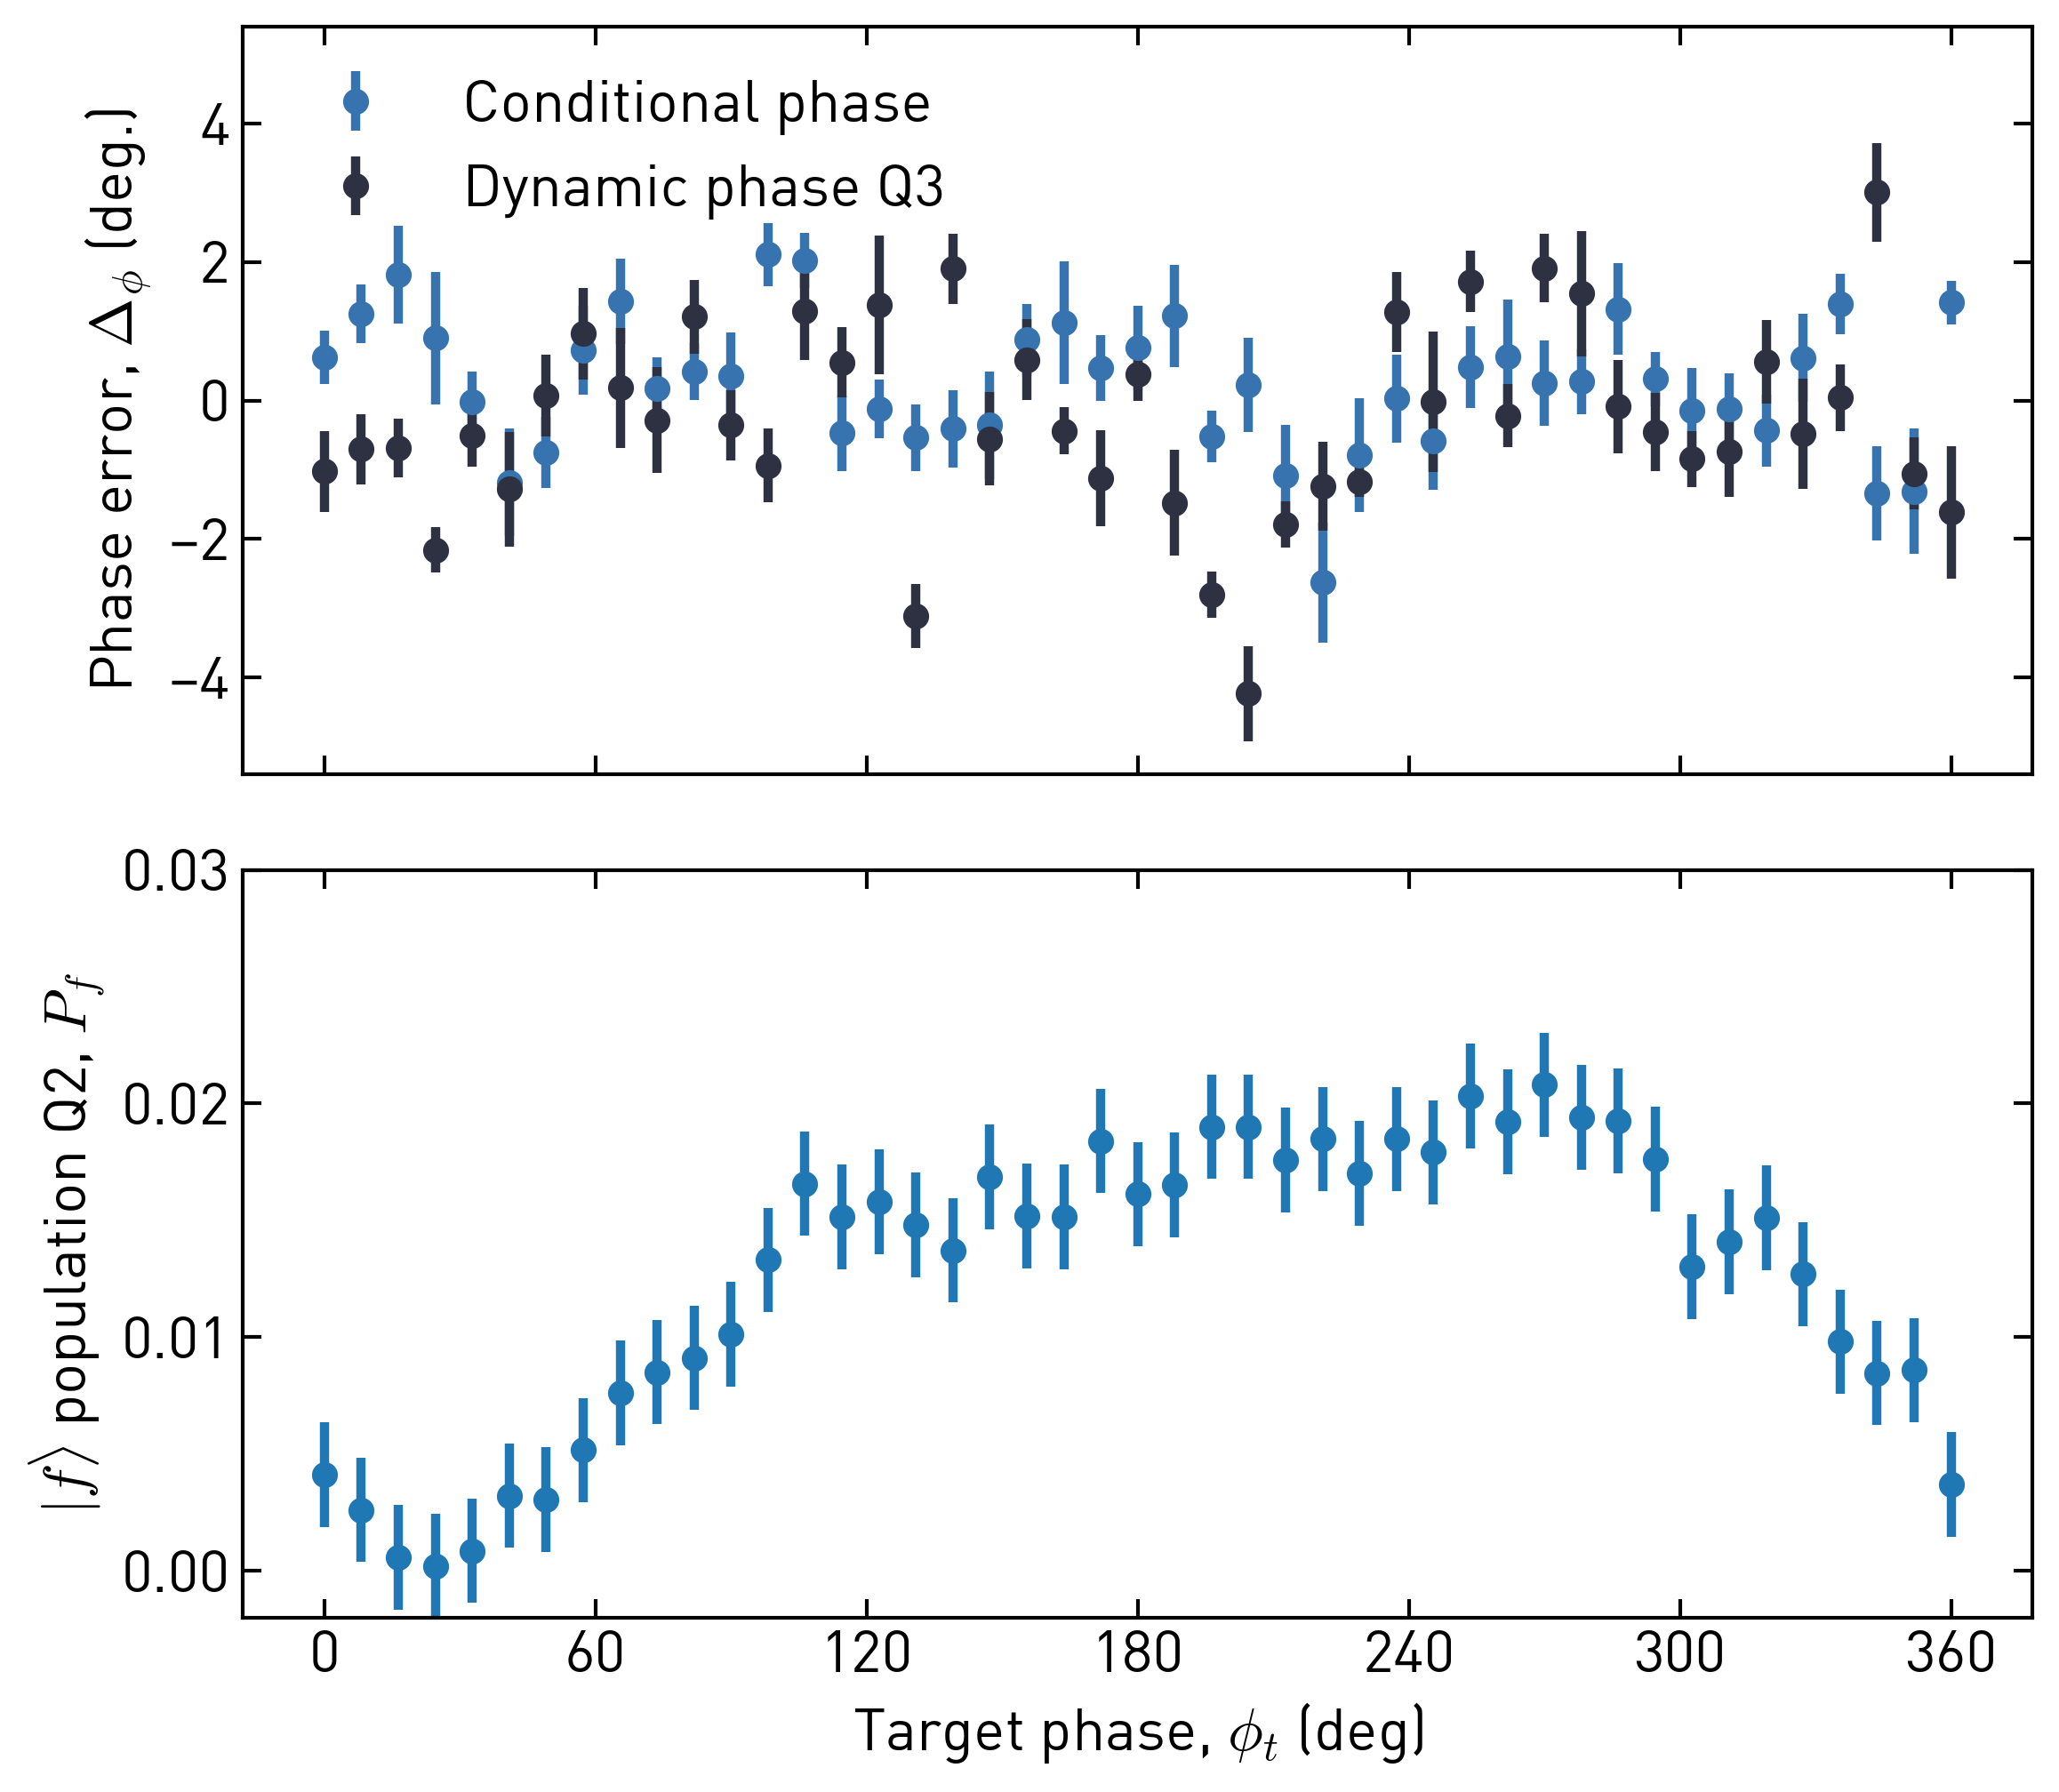

In [38]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 7))
# colors = get_color_list(2, 'Accent')

# COND PH
ax[0].set_prop_cycle(color=[colors[0], colors[4]])
ax[0].set_ylim([-3.6*1.5,3.6*1.5])
ax[0].set_ylabel(r"Phase error, $\Delta_\phi}$ (deg.)")

ax[0].set_xticks(np.arange(0, 420, 60))

# errobar plot 
ax[0].errorbar(target_phases*180/np.pi, cph_carb_angle_error , cph_carb_std*180/np.pi, marker='o', 
               fmt=' ', label='Conditional phase', capsize=0, alpha=1, )

# DYN PH
# errobar plot 
ax[0].errorbar(target_phases*180/np.pi,dph_carb_angle_error   , dph_carb_std*180/np.pi, marker='o',
               fmt=' ', label='Dynamic phase Q3', capsize=0, alpha=1)
ax[0].legend()


# LEAKAGE
ax[1].errorbar(target_phases*180/np.pi, data_leakage_carb, data_leakage_carb_std , marker='o', fmt=' ', 
            label='C-Arb.', capsize=0, alpha=1)
# ax[1].plot(target_phases*180/np.pi, pop_loss- data_leakage_carb)
ax[1].set_ylim([-0.002, 0.03])
ax[1].set_xlabel(r"Target phase, $\phi_t$ (deg)")
ax[1].set_ylabel(r"$|f\rangle$ population Q2, $P_f$")
fig.tight_layout()

In [39]:
fig.savefig(figsave_base + "ch4_characterization_phase_error_and_leakage_{:%Y%m%d_%H%M%S}.png".format(datetime.now()))

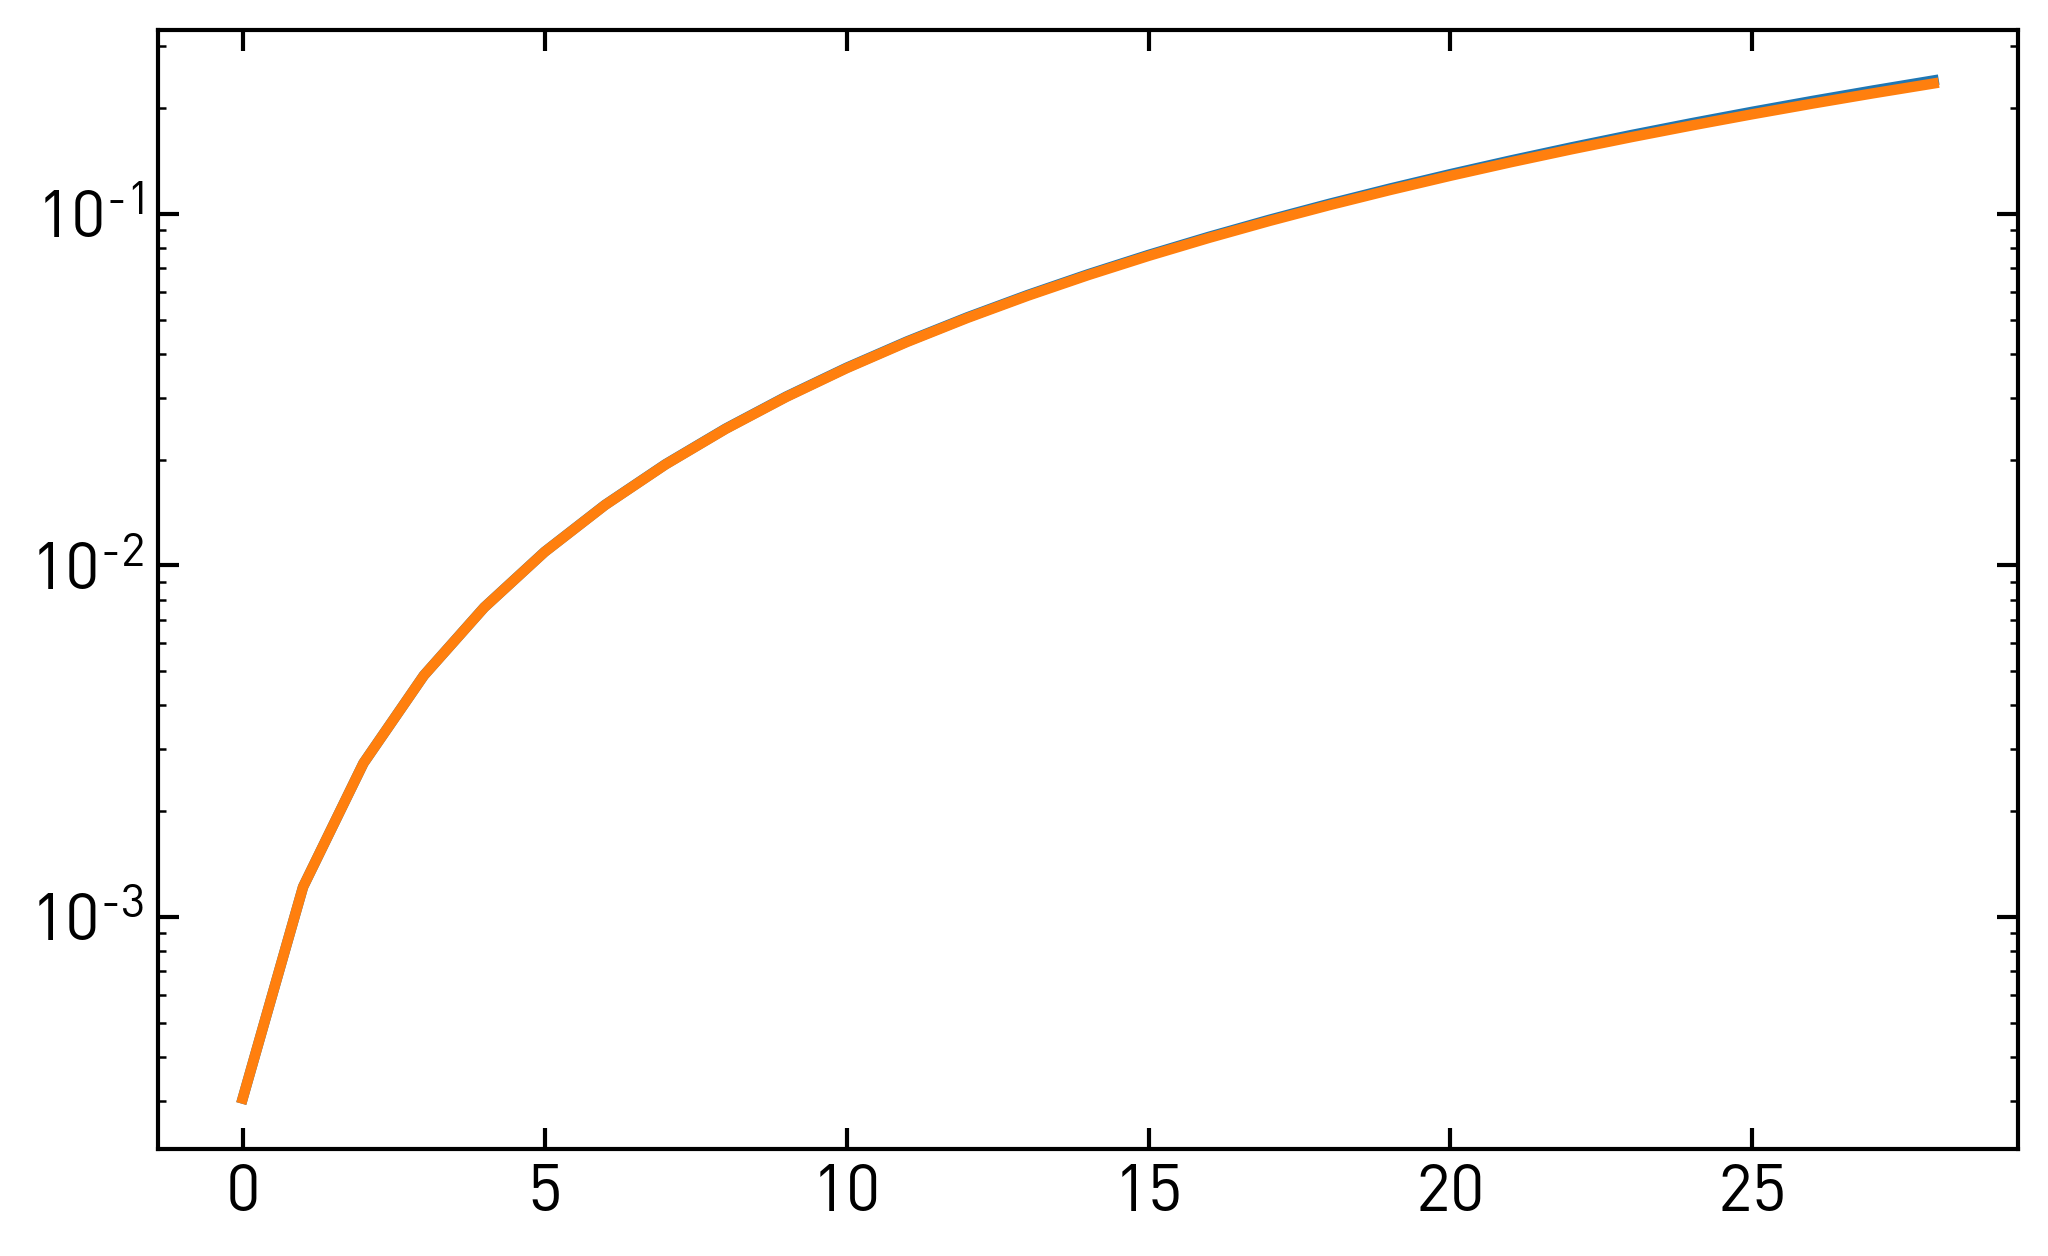

In [74]:
plt.plot(1-(1-((np.arange(1,30)*np.pi/180)**2)/2)**2)
plt.plot(1-(np.cos(np.arange(1,30)*np.pi/180))**2)
plt.yscale('log')

### cond phase distrib error

In [87]:
print(np.mean(cph_carb_angle_error))
print(np.std(cph_carb_angle_error))

0.2325009235611357
0.9694108380332834


In [97]:
sigma = 2*np.pi/180 #np.std(cph_carb_angle_error*np.pi/180)
n_sigma = 1
(1-(sigma*n_sigma)**2/2)**2

0.9987819014879429

### dyn phase distrib error

In [91]:
print(np.mean(dph_carb_angle_error))
print(np.std(dph_carb_angle_error))

-0.2837997630420179
1.393345814674334


In [95]:
sigma = 2*np.pi/180 #np.std(dph_carb_angle_error*np.pi/180)
n_sigma = 1
(1-(sigma*n_sigma)**2/2)**2

0.9987819014879429

In [430]:
import scipy.stats as stats
stats.pearsonr((cph_carb_angle_error-np.mean(cph_carb_angle_error))/np.std(cph_carb_angle_error), 
               (dph_carb_angle_error-np.mean(dph_carb_angle_error))/np.std(dph_carb_angle_error))

(0.05101103339541802, 0.7393004863988384)

In [37]:
400e3*2*np.pi*1e-7*180/np.pi

14.399999999999999